# **Process pseudobulks for subtype prediction**



# **Imports**

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell/augmented/"


exp_id = "all-cellType"
res_id = "cellType"
curr_treatment = "drug"
result_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [3]:
# now get the sc ref training data

# read in order
# oritinal samples
sample_order = ['Samp_2251', 'Samp_2293', 'Samp_2380', 'Samp_2467', 'Samp_2497']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, _, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])



Samp_2251
Samp_2293
Samp_2380
Samp_2467
Samp_2497


In [4]:
gene_df

gene_ids
AL627309.1    AL627309.1
AL627309.3    AL627309.3
AL627309.5    AL627309.5
AP006222.2    AP006222.2
AL732372.1    AL732372.1
                 ...    
AC136616.2    AC136616.2
AC141272.1    AC141272.1
AC007325.1    AC007325.1
AC007325.4    AC007325.4
AC007325.2    AC007325.2
Name: gene_ids, Length: 31178, dtype: object

In [5]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type
0,Samp_2251,CTRL,Train,random,sc_ref
1,Samp_2251,CTRL,Train,random,sc_ref
2,Samp_2251,CTRL,Train,random,sc_ref
3,Samp_2251,CTRL,Train,random,sc_ref
4,Samp_2251,CTRL,Train,random,sc_ref
...,...,...,...,...,...
2095,Samp_2497,CTRL,Train,cell_type_specific,sc_ref
2096,Samp_2497,CTRL,Train,cell_type_specific,sc_ref
2097,Samp_2497,CTRL,Train,cell_type_specific,sc_ref
2098,Samp_2497,CTRL,Train,cell_type_specific,sc_ref


In [6]:
X_concat

gene_ids,AL627309.1,AL627309.3,AL627309.5,AP006222.2,AL732372.1,AL669831.2,LINC01409,FAM87B,LINC01128,LINC00115,...,AC004556.3,AC233755.2,AC233755.1,AC136352.3,AC136616.1,AC136616.2,AC141272.1,AC007325.1,AC007325.4,AC007325.2
0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,0.0,19.0,2.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,25.0,1.0,...,0.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,25.0,2.0,...,0.0,223.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
0,0.0,0.0,4.0,0.0,0.0,0.0,21.0,0.0,20.0,4.0,...,0.0,19.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,0.0,0.0,6.0,0.0,1.0,0.0,35.0,0.0,35.0,3.0,...,0.0,13.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,15.0,0.0,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,12.0,0.0,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,16.0,0.0,...,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,14.0,0.0,...,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# double check all the pseudobulks/bulks were read in
meta_concat.sample_id.value_counts()

sample_id
Samp_2251    2100
Samp_2293    2100
Samp_2380    2100
Samp_2467    2100
Samp_2497    2100
Name: count, dtype: int64

In [8]:
Y_concat

,Plasma cells,B cells,T cells,Endothelial cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,Macrophages,Mast cells
0,0.015000,0.085000,0.360000,0.045000,0.300000,0.095000,0.005000,0.010000,0.010000,0.040000,0.035000
0,0.070000,0.070000,0.035000,0.100000,0.165000,0.165000,0.040000,0.045000,0.140000,0.030000,0.140000
0,0.225000,0.030000,0.070000,0.175000,0.065000,0.015000,0.010000,0.190000,0.120000,0.025000,0.075000
0,0.175000,0.010000,0.040000,0.020000,0.470000,0.005000,0.040000,0.005000,0.170000,0.060000,0.005000
0,0.010000,0.065000,0.010000,0.130000,0.015000,0.030000,0.020000,0.295000,0.320000,0.005000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...
0,0.026604,0.002890,0.010341,0.047804,0.020454,0.020995,0.019246,0.030462,0.023407,0.025306,0.772491
0,0.002116,0.001691,0.003243,0.000644,0.003703,0.005313,0.001941,0.003569,0.000648,0.004316,0.972817
0,0.025838,0.005547,0.004899,0.004423,0.009855,0.007586,0.012293,0.003255,0.047177,0.006951,0.872177
0,0.010354,0.000653,0.008314,0.002285,0.004506,0.005219,0.002218,0.001334,0.001800,0.003537,0.959781


# Plot all data

In [9]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type
0,Samp_2251,CTRL,Train,random,sc_ref
1,Samp_2251,CTRL,Train,random,sc_ref
2,Samp_2251,CTRL,Train,random,sc_ref
3,Samp_2251,CTRL,Train,random,sc_ref
4,Samp_2251,CTRL,Train,random,sc_ref
...,...,...,...,...,...
2095,Samp_2497,CTRL,Train,cell_type_specific,sc_ref
2096,Samp_2497,CTRL,Train,cell_type_specific,sc_ref
2097,Samp_2497,CTRL,Train,cell_type_specific,sc_ref
2098,Samp_2497,CTRL,Train,cell_type_specific,sc_ref


/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.006s...
[t-SNE] Computed neighbors for 1000 samples in 0.567s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 21927.737024
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.032639
[t-SNE] KL divergence after 500 iterations: 0.603889
(1000, 2)
(1000, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_19037/3792966746.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


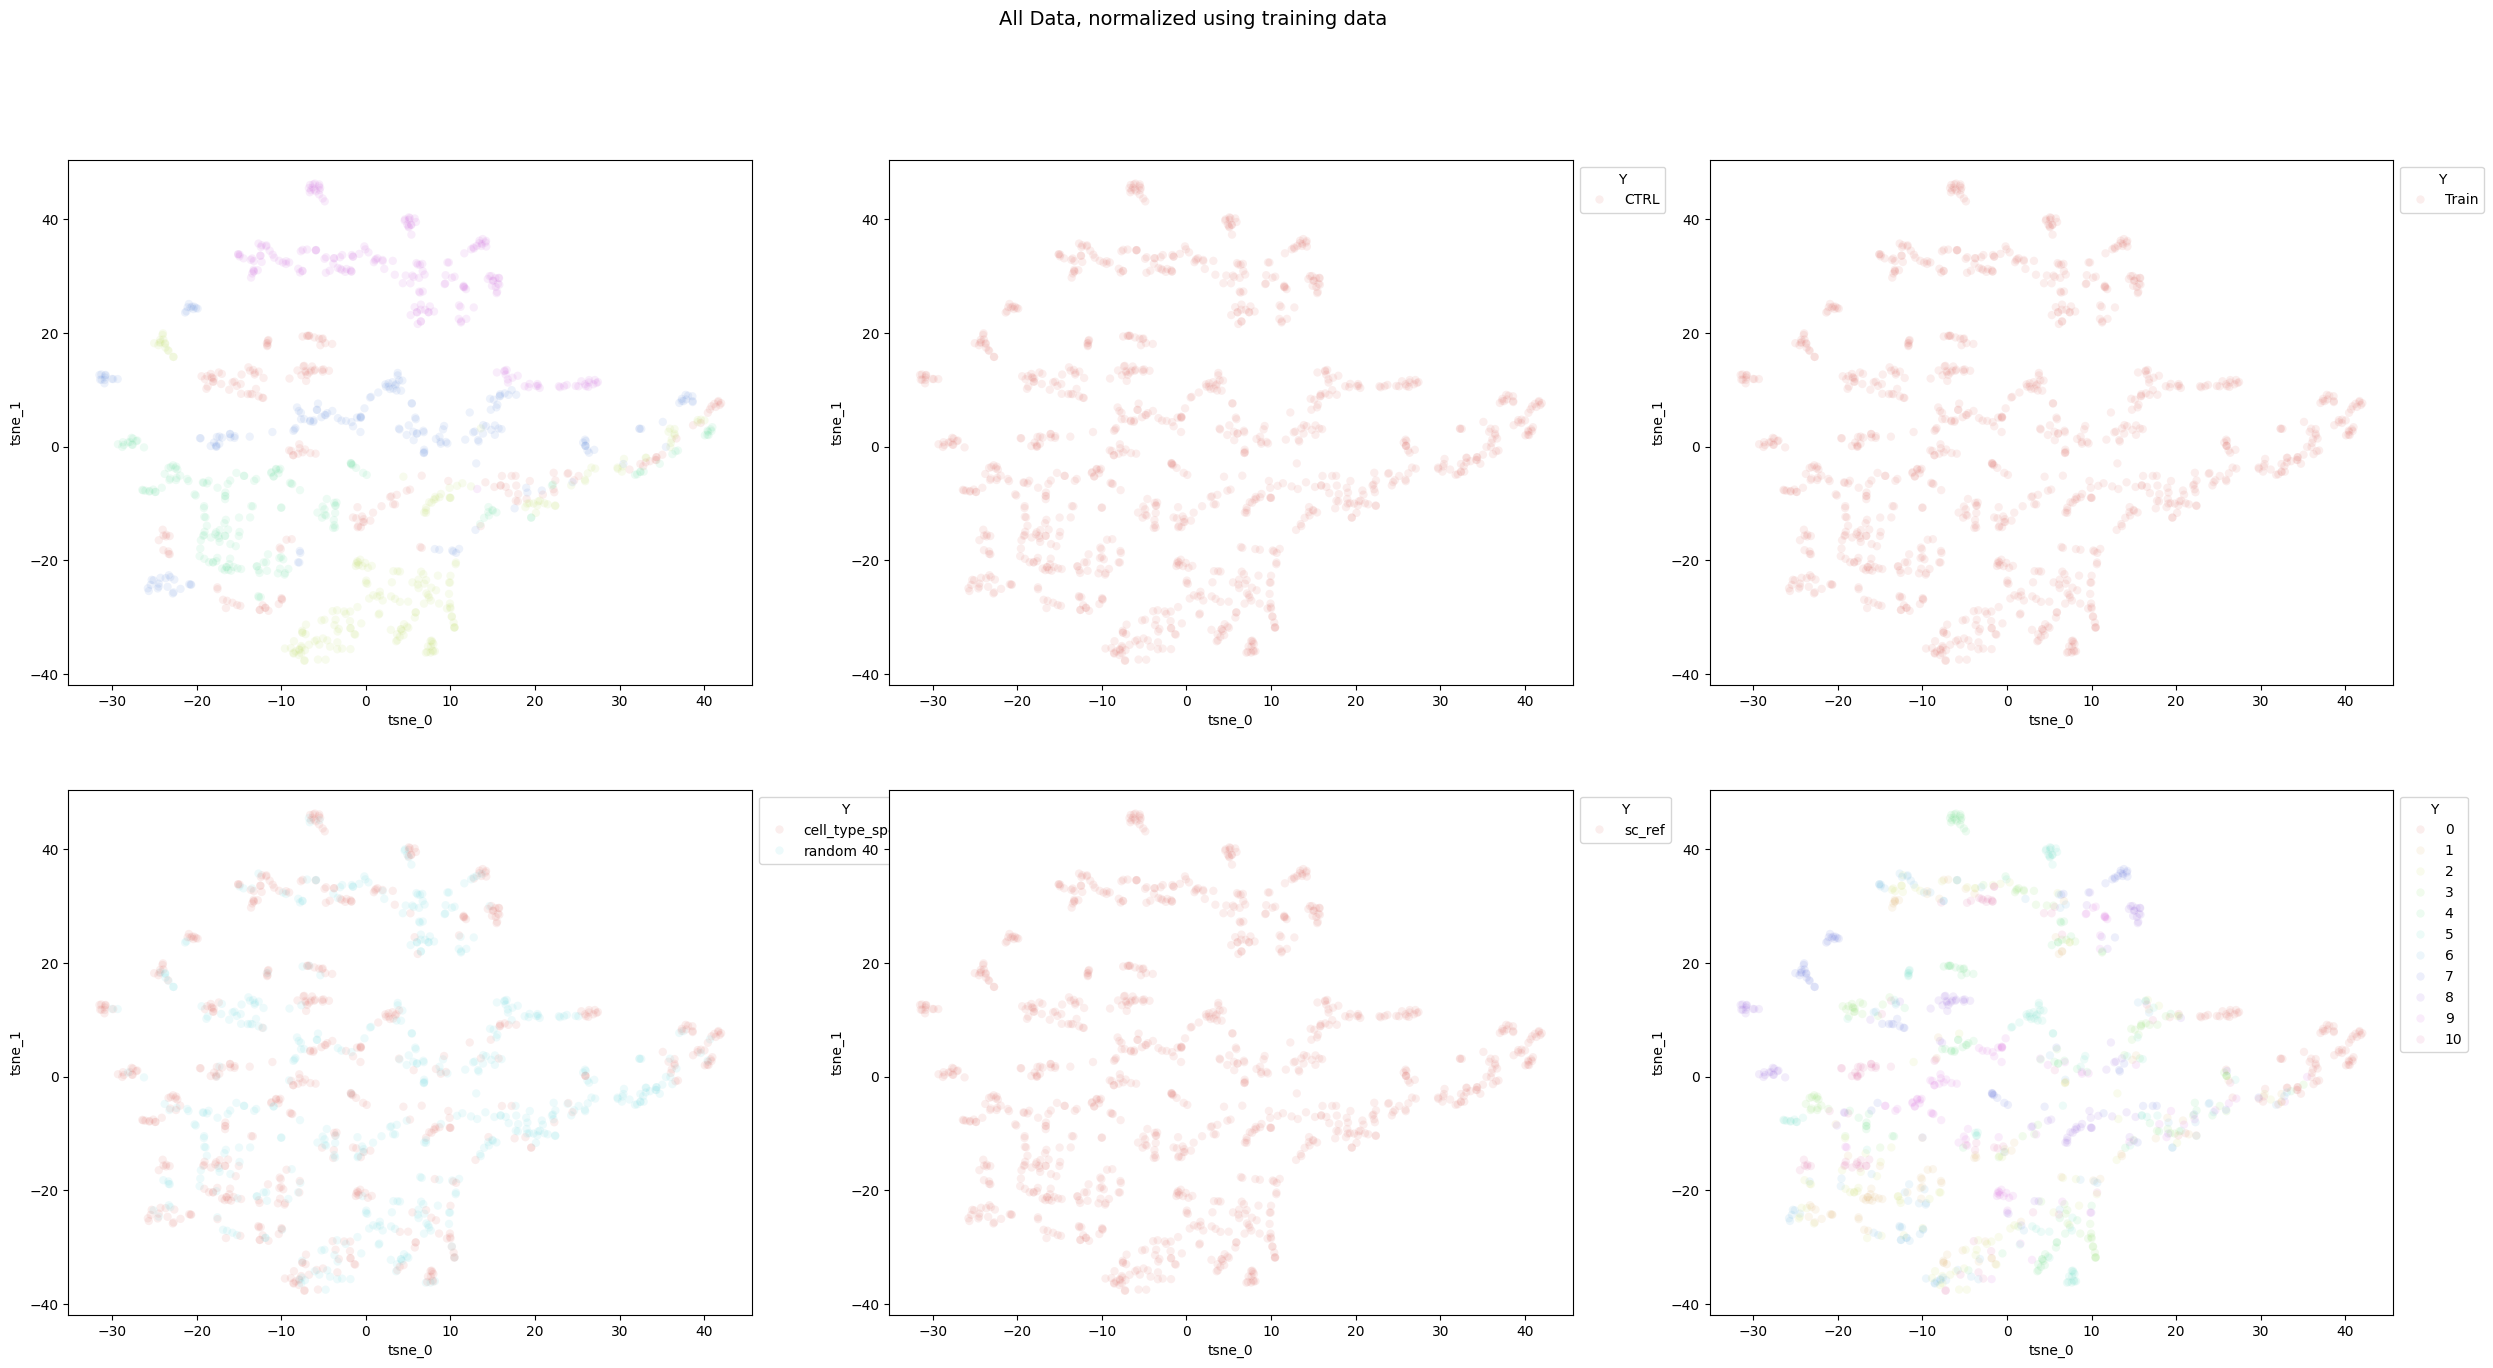

In [10]:
## plot samples
idx_tmp = np.random.choice(range(X_concat.shape[0]), 1000, replace=True)


plot_df = vp.get_tsne_for_plotting(X_concat.iloc[idx_tmp])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_concat.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


In [11]:
Y_concat

,Plasma cells,B cells,T cells,Endothelial cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,Macrophages,Mast cells
0,0.015000,0.085000,0.360000,0.045000,0.300000,0.095000,0.005000,0.010000,0.010000,0.040000,0.035000
0,0.070000,0.070000,0.035000,0.100000,0.165000,0.165000,0.040000,0.045000,0.140000,0.030000,0.140000
0,0.225000,0.030000,0.070000,0.175000,0.065000,0.015000,0.010000,0.190000,0.120000,0.025000,0.075000
0,0.175000,0.010000,0.040000,0.020000,0.470000,0.005000,0.040000,0.005000,0.170000,0.060000,0.005000
0,0.010000,0.065000,0.010000,0.130000,0.015000,0.030000,0.020000,0.295000,0.320000,0.005000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...
0,0.026604,0.002890,0.010341,0.047804,0.020454,0.020995,0.019246,0.030462,0.023407,0.025306,0.772491
0,0.002116,0.001691,0.003243,0.000644,0.003703,0.005313,0.001941,0.003569,0.000648,0.004316,0.972817
0,0.025838,0.005547,0.004899,0.004423,0.009855,0.007586,0.012293,0.003255,0.047177,0.006951,0.872177
0,0.010354,0.000653,0.008314,0.002285,0.004506,0.005219,0.002218,0.001334,0.001800,0.003537,0.959781


In [12]:
X_concat

gene_ids,AL627309.1,AL627309.3,AL627309.5,AP006222.2,AL732372.1,AL669831.2,LINC01409,FAM87B,LINC01128,LINC00115,...,AC004556.3,AC233755.2,AC233755.1,AC136352.3,AC136616.1,AC136616.2,AC141272.1,AC007325.1,AC007325.4,AC007325.2
0,0.0,0.0,3.0,0.0,0.0,0.0,12.0,0.0,19.0,2.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,25.0,1.0,...,0.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,25.0,2.0,...,0.0,223.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
0,0.0,0.0,4.0,0.0,0.0,0.0,21.0,0.0,20.0,4.0,...,0.0,19.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0,0.0,0.0,6.0,0.0,1.0,0.0,35.0,0.0,35.0,3.0,...,0.0,13.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,15.0,0.0,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,12.0,0.0,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,16.0,0.0,...,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,14.0,0.0,...,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
pd.DataFrame(gene_df)

,gene_ids
gene_ids,
AL627309.1,AL627309.1
AL627309.3,AL627309.3
AL627309.5,AL627309.5
AP006222.2,AP006222.2
AL732372.1,AL732372.1
...,...
AC136616.2,AC136616.2
AC141272.1,AC141272.1
AC007325.1,AC007325.1


In [14]:
result_ad_file_tsv = f"{sc_aug_data_path}/{exp_id}.tsv"
X_concat.to_csv(result_ad_file_tsv, sep="\t")

In [15]:
# make anndata

# write out anndata for R to run consensusOV

meta_concat.index = range(0,meta_concat.shape[0])
Y_concat.index = meta_concat.index
X_concat.index = meta_concat.index
X_concat.columns

full_meta = pd.concat([meta_concat, Y_concat], axis=1)

adata = ad.AnnData(X=X_concat, obs=full_meta, var=pd.DataFrame(gene_df))

adata.write(result_ad_file)

adata

/Users/davidnat/Documents/projects/davidsonlab/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 10500 × 31178
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'Plasma cells', 'B cells', 'T cells', 'Endothelial cells', 'Monocytes', 'Fibroblasts', 'NK cells', 'Epithelial cells', 'DC', 'Macrophages', 'Mast cells'
    var: 'gene_ids'